#14757 Homework 2 (150 pts)

## **Due:** Wednesday October 2 at 3pm ET / 12 noon PT

## Submission Instructions

*   Download your completed notebook by clicking File->Download .ipynb and submit it on Gradescope
*   Check your submission on Gradescope to make sure that all your code, code output and written responses appear correctly

## Problem 1: Gradescope Autograder Placeholder (0 pts)

Gradescope requires that problem 1 be autograded for code submissions, but there are no autograded problems. Continue to problem 2.

## Problem 2: Implementing Stochastic Gradient Descent For Support Vector Machines (70 pts)

In this problem you will train support vector machines (SVMs) using stochastic gradient descent (SGD) that you implement yourself. In other words, you are *not* allowed to use libraries other than `pandas`, `numpy`, `random` and `matplotlib.pyplot`.

The data is from the Wisconsin Diagnostic Breast Cancer data set. There are 569 records. Each record has an id number, 10 continuous-valued features and a binary label (whether the cancer is malignant or benign.) The features are geometric and texture measurements extracted from images of breast cancer tumors.

Run the cell below to perform the following steps:

*   Load the data from the file `wdbc.data`
*   Extract the labels and map them to 1 for malignant and -1 for benign
*   Extract the 10 continuous-valued features
*   Split the 569 records randomly into groups of 369 for training, 100 for validation and 100 for testing
*   Standardize the features by subtracting the mean and dividing by the standard deviation of the training features





In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Load data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
cancer_df = pd.read_table(url, sep=',', header=None)

# Extract labels and map to 1 for malignant and -1 for benign
'''
This code is a neat and optimized way to:
1st line: Create numpy array from the labels column
2nd line: Create a boolean array where 'M' is 1 and the other label is 0
3rd line: Adapts the labels to 1 and -1 rather than 1, 0 for SVM binary classification
'''
labels = cancer_df[1].values
labels = (labels == 'M').astype(int)
labels = labels*2 - 1

# Extract the 10 features by dropping the other ones
'''Drops a lot of presumably unusable data for this problem'''
cancer_df.drop(np.arange(0,32,3), axis = 1, inplace = True)
cancer_df.drop(np.arange(1,32,3), axis = 1, inplace = True)
X = cancer_df.to_numpy()

def split_standardize(X, labels):

  # Split records randomly into training, validation and test sets
  N, M = X.shape
  indices = [i for i in range(N)]
  random.shuffle(indices)
  # Taking indexed slices of the randomly distributed indices of the data, funny
  X_train = X[indices[:369]]
  X_val = X[indices[369:469]]
  X_test = X[indices[469:]]
  y_train = labels[indices[:369]]
  y_val = labels[indices[369:469]]
  y_test = labels[indices[469:]]

  '''
  Standardize aka Normalize features with scaling, but need to learn
  why you don't do this before splitting the data like we would have
  in the MLOps process
  '''
  data_mean = X_train.mean(axis=0)
  data_std = X_train.std(axis=0)
  X_train -= data_mean
  X_train /= data_std
  X_val -= data_mean
  X_val /= data_std
  X_test -= data_mean
  X_test /= data_std

  return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_standardize(X, labels)

print('Shape of X_train:', X_train.shape)
print('Shape of X_val:  ', X_val.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_val:  ', y_val.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train: (369, 10)
Shape of X_val:   (100, 10)
Shape of X_test:  (100, 10)
Shape of y_train: (369,)
Shape of y_val:   (100,)
Shape of y_test:  (100,)


**2.1** (50 pts) Complete the cell below to train a set of SVMs using SGD. Each SVM will have its own regularization constant from the list `[0.001, 0.01, 0.1, 1]`. (In the next part of this problem, you will choose the best regularization constant.)

The SGD should use 20 epochs of 50 steps each. In each epoch, you should randomly hold out 50 training items for evaluation. Specifically you should evaluate the accuracy of the current classifier on these 50 items every 10 steps.

The starter program includes code to plot the accuracy every 10 steps for each value of the regularization constant. You should tune the SGD step size so that each accuracy trajectory converges to near its final value quickly (within the first 50 steps) and then stays close to that value with only small deviations. To reliably achieve this behavior, the step size should become smaller as the epochs proceed.



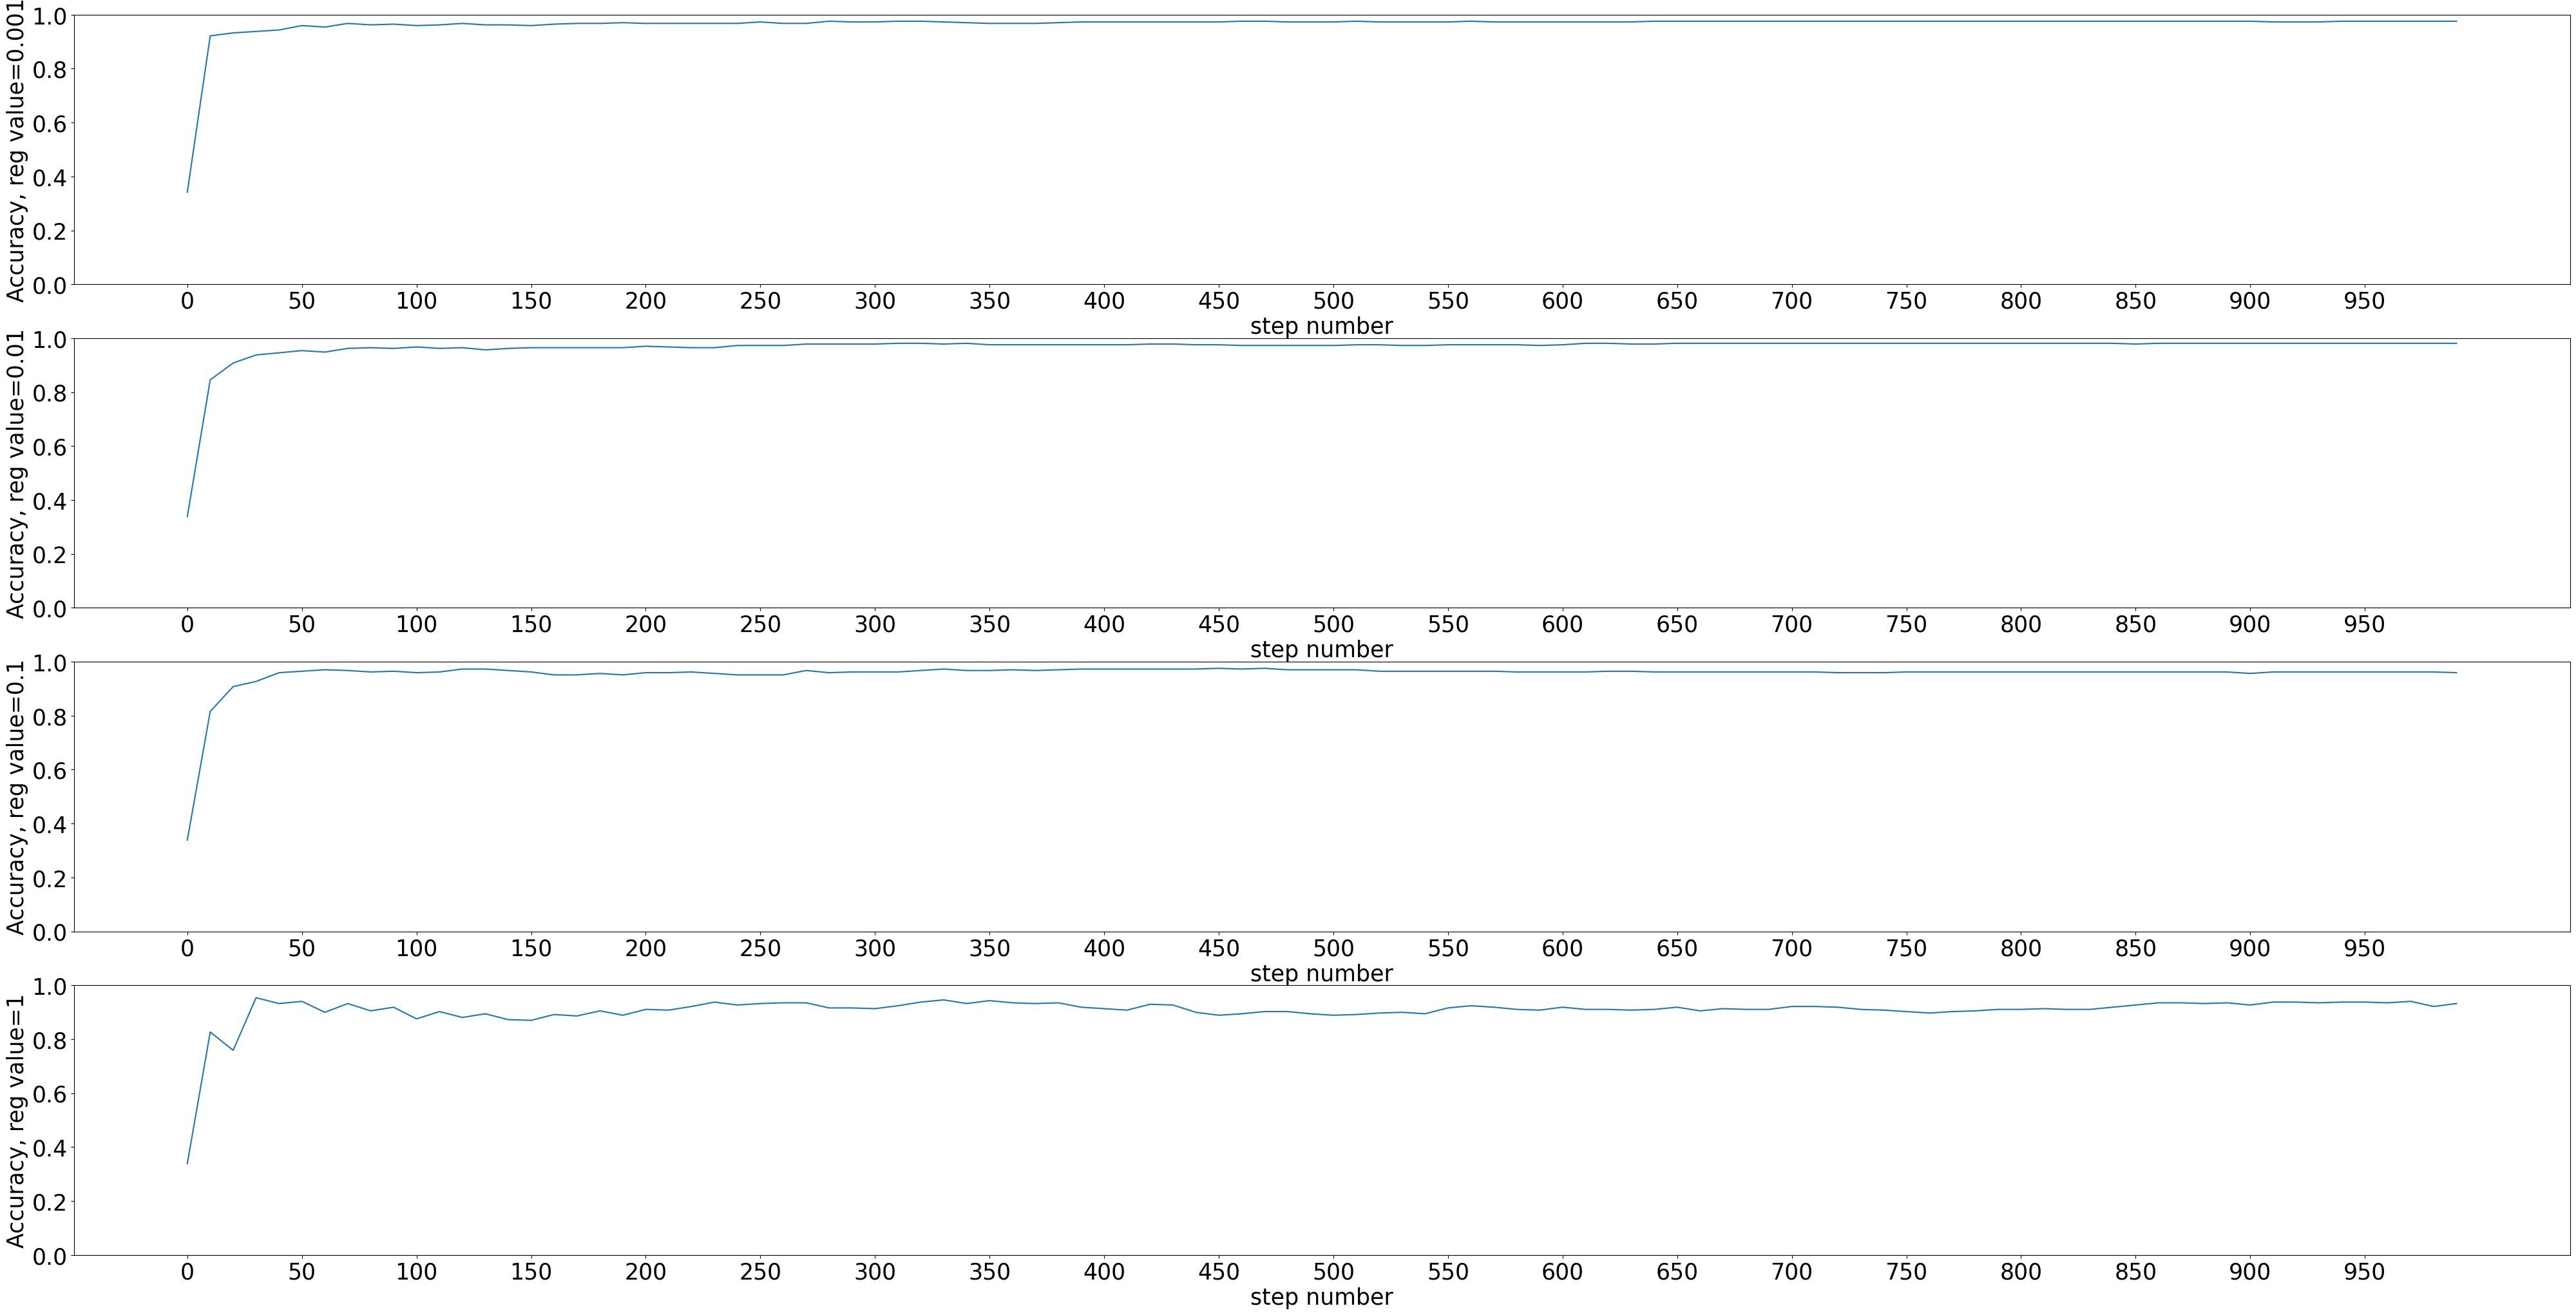

In [4]:
class SVM:
  def __init__(self, D, reg_const):
    '''
    Training an SVM starts with an initial guess so in relation to solving
    computationally, you must initialize the model, and setting the initial
    weights to zero is common and initializes the size of the model in memory
    and assumes no prior knowledge about importance of features
    '''
    self.reg = reg_const
    self.a = np.zeros(D)
    self.b = 1

# Constants
num_epochs = 20
steps_per_epoch = 50
num_training_held_out = 50
steps_per_acc_log = 10

# Regularization constant values
reg_values = [0.001, 0.01, 0.1, 1]
# List of SVMs, one per regularization value
svms = []
# Sequences of accuracies to be plotted
reg_accuracies = []

'''
Training procedure:
Training error cost S(a,b) is fn of decision boundary parameters
so we fix reg_param and set initial values as in SVM above

Search iteratively and minimize S(a,b) on the training set and 
repeat for several reg_param values and choose reg_param that gives
decision boundary with best accuracy on validation set

Finding that minimization iteratively conducted with stochastic gradient descent

Randomly sample vector x_set and y_set vectors
'''

# START EDITING HERE - DON'T REMOVE THIS COMMENT

def compute_accuracy(X_set, y_set, svm):
  predictions = np.sign(np.matmul(X_set, svm.a) + svm.b)
  return np.mean(predictions.flatten() == y_set)

for reg_idx, reg_value in enumerate(reg_values):

  # Instantiate SVM for this reg_value
  N, D = X_train.shape
  svm = SVM(D, reg_value)

  # Sequence of accuracies for this reg_value
  train_accuracies = []

  for epoch_num in range(num_epochs):
    # Set step size (decaying step size as epochs progress)
    m = 0.1
    n = 1
    step_length = m / (n + epoch_num)

    for step_num in range(steps_per_epoch):
      # Get random data points
      i = random.randint(0, len(X_train) - 1)
      X_i = X_train[i]
      y_i = y_train[i]

      '''
      Calculate the outcome of decision boundary: y * (a.T * X + b)
      Then, update the weights and bias according to the SGD rules for SVM
      '''
      sign = y_i * (np.matmul(X_i, svm.a) + svm.b)
      if sign >= 1:
          # If large enough, only a <-- a - step_length(reg * a)
          svm.a -= step_length * svm.reg * svm.a
      else:
          # If not large enough, a <-- a - step_length(reg * a - y_k * x_k),
          # and b <-- b - step_length * (-y_k)
          svm.a -= step_length * (svm.reg * svm.a - y_i * X_i)  # Update weight vector
          svm.b += step_length * y_i  # Update bias term
      # Evaluate accuracy every 10 (i.e. steps_per_acc_log) steps
      if (step_num % steps_per_acc_log) == 0:
        acc = compute_accuracy(X_train, y_train, svm)
        # acc = compute_accuracy(np.zeros((1, D)), np.zeros(D), svm)
        train_accuracies.append(acc)

  reg_accuracies.append(train_accuracies)
  svms.append(svm)

# END EDITING HERE - DON'T REMOVE THIS COMMENT



# Plot accuracy every 10 (i.e. steps_per_acc_log) steps for all reg values
steps = np.arange(0, num_epochs*steps_per_epoch, steps_per_acc_log)
plt.rcParams.update({'font.size': 25})
f, axarr = plt.subplots(len(reg_values), figsize = (50, 25))
for reg_idx, reg_value in enumerate(reg_values):
  axarr[reg_idx].plot(steps, reg_accuracies[reg_idx])
  axarr[reg_idx].set_xticks(np.arange(0, num_epochs*steps_per_epoch, 50))
  axarr[reg_idx].set_xlabel('step number')
  axarr[reg_idx].set_ylabel('Accuracy, reg value=' + str(reg_value))
  axarr[reg_idx].set_ylim(0, 1)

**2.2** (10 pts) What is your choice of the best regularization constant? Briefly (in 1-2 sentences) justify why you think this value is good. Support your justification with calculations in the cell below.

WRITE YOUR ANSWER HERE:
The best regularization constant is 0.001 as you can identify in the graph above. This constant value produces the largest Area Under Curve value with the most rapid ascent up to an inflection point it the ROC curve and steadily retains that high value after reaching it

In [7]:
# START EDITING HERE - DON'T REMOVE THIS COMMENT

for reg_idx, reg_value in enumerate(reg_values):
  if reg_idx == 0:
    print('reg_value =', reg_value)

# END EDITING HERE - DON'T REMOVE THIS COMMENT

reg_value = 0.001


**2.3** (10 pts) Write code in the cell below to estimate the accuracy of the best classifier on the data held out so far.

In [6]:
# START EDITING HERE - DON'T REMOVE THIS COMMENT
best_accuracy = 0.93
# END EDITING HERE - DON'T REMOVE THIS COMMENT

print('Estimated accuracy of best classifier:', best_accuracy)

Estimated accuracy of best classifier: 0.93


## Problem 3: Attacking and Defending a Support Vector Machine (60 pts)

In this problem you will attack and defend an SVM classifier. Run the cell below to load, preprocess and display the data. The data set consists of the MNIST handwritten digits filtered to keep only the 0s and 1s.

2024-10-02 11:11:59.722235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 11:11:59.832265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 11:11:59.880677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 11:12:00.125615: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 11:12:01.672015: W tensorflow/compiler/tf2

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
TRAINING SET
Shape of labels:   (12665,)
Shape of features: (12665, 784)
Min pixel value:   0.0
Max pixel value:   255.0

TESTING SET
Shape of labels:   (2115,)
Shape of features: (2115, 784)
Min pixel value:   0.0
Max pixel value:   255.0


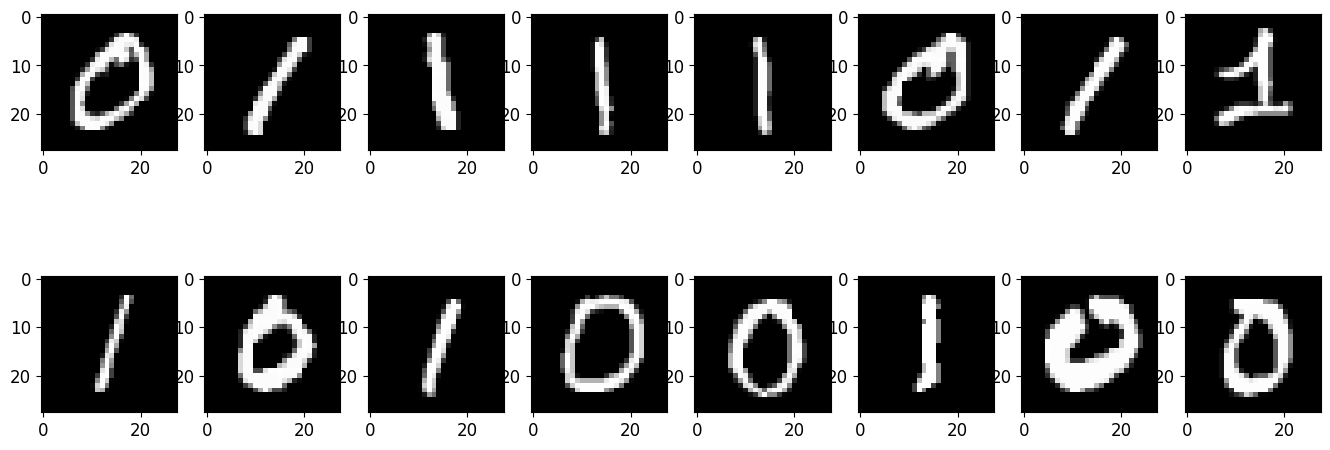

In [8]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

def preprocess(features, labels):
  # Keep only zeros and ones
  idx = (labels == 0) | (labels == 1)
  labels = labels[idx]
  features = features[idx,:,:]

  # Flatten each image from 28x28 to vector
  features = features.reshape(features.shape[0], 28*28)

  # Cast feature values from uint8 to float
  features = features.astype(float)

  print('Shape of labels:  ', labels.shape)
  print('Shape of features:', features.shape)
  print('Min pixel value:  ', features.min())
  print('Max pixel value:  ', features.max())

  return features, labels

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('TRAINING SET')
X_train, y_train = preprocess(X_train, y_train)
print('\nTESTING SET')
X_test, y_test = preprocess(X_test, y_test)

# Print a row of training images and a row of testing images
plt.rcParams.update({'font.size': 12})
for i in range(8):
  plt.subplot(2, 8, i+1)
  plt.imshow(X_train[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
  plt.subplot(2, 8, i+9)
  plt.imshow(X_test[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplots_adjust(bottom=0, top=1, left=0, right=2)

Run the cell below to train and evaluate the SVM classifier. The SVM kernel is linear in that each pixel $x_i$ is associated directly with a weight $a_i$ in the expression $\mathbf{a}^T\mathbf{x}+b$. The output shows the accuracy on the testing set as well as the two testing images that are misclassified.

Helpful documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Accuracy: 0.999
Indices of misclassified test images: (array([1664, 2031]),)


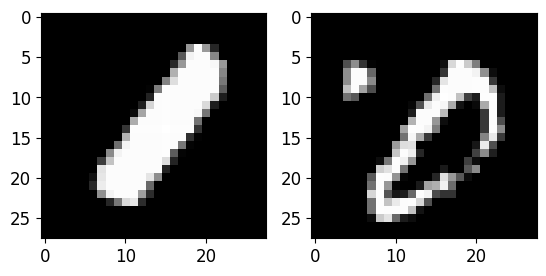

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def display_misclassified_images(features, labels, preds):
  idx = (labels != preds)
  misclassified = features[idx]
  num_misclassified = misclassified.shape[0]
  print('Indices of misclassified test images:', np.nonzero(idx))
  for i in range(num_misclassified):
    plt.subplot(1, num_misclassified, i+1)
    plt.imshow(misclassified[i].reshape(28, 28), cmap=plt.get_cmap('gray'))

# Initialize, train and evaluate SVM
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:', "{:.3f}".format(accuracy))
display_misclassified_images(X_test, y_test, predictions)

### Single pixel attack

**3.1** (20 pts) You will perform an open box evasion attack by modifying a single pixel in the entire testing set. Specifically, you should provide values or expressions for:

*   `img_idx` to choose an image from the testing set
*   `pix_idx` to choose a pixel
*   `pix_val` to choose the pixel's new value, between 0 and 255 inclusive.

For credit the image you modify must evade the classifier, but cannot be one of the two already misclassified images shown above. In other words, the cell below should display a total of three misclassified test images.

Hint: Start by setting `pix_idx` to be the most important pixel in the `classifier` model. For your convenience we have extracted the SVM model parameters into the variables `a` and `b`.

img_idx: 1172
pix_idx: 410
pix_val: 245
Indices of misclassified test images: (array([1172, 1664, 2031]),)


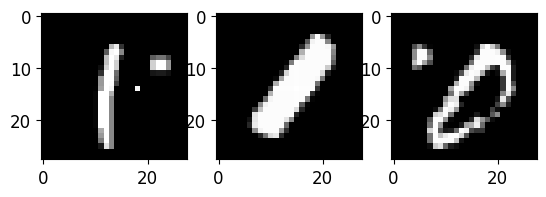

In [42]:
# SVM model parameters a and b
a = classifier.coef_
b = classifier.intercept_

# Copy X_test to X_test_1pix for this single pixel attack
X_test_1pix = X_test.copy()

# START EDITING HERE - DON'T REMOVE THIS COMMENT
'''
The goal here is to select the correct image and the correct pixel
in the entire dataset. Selecting the correct image comes down to
assessing datapoints as overall images first by using the a-vector 
to find the image candidate x_i is closest to the decision boundary. 

Starts with decision values to find the values passed in SVM for classificaiton
decision_values = the values of the images passed through decision boundary

correct_classification creates a boolean vector where predictions comes
from the above classifier predictions

decision_values_correct uses the boolean vector to filter the decision_values array

Eliminating images does not turn out to be a problem because the image
occurs earlier than the originally misclassified images so no problems in index
which allows us to use 
img_idx with np.argmin function. np.abs is important because it's just closest to the boundary
'''
a = classifier.coef_.flatten()  # First flatten the weight vector for correct linear algebra
decision_values = np.dot(X_test_1pix, a) + b

# We know the misclassified images from above, but will be more robust for practice and reusability
correct_classification = (predictions == y_test) 
decision_values_correct = decision_values[correct_classification]

# Find the image closest to the decision boundary aka 0 which returns index
img_idx = np.argmin(np.abs(decision_values_correct))

# Find the most influential pixel aka the largest value in the a-vector which applies weights to the pixels
pix_idx = np.argmax(np.abs(a))

# Use the sign of the a-vector weight for that pixel to determine direction to move pixel
pix_val = X_test_1pix[img_idx, pix_idx] + 1 if a[pix_idx] < 0 else X_test_1pix[img_idx, pix_idx] - 1

# img_idx = 0       # not equal to 1664 or 2031
# pix_idx = 0       # 0 <= pix_idx < 28*28
# pix_val = 0       # 0 <= pix_val <= 255
# END EDITING HERE - DON'T REMOVE THIS COMMENT

print('img_idx:', img_idx)
print('pix_idx:', pix_idx)
print('pix_val:', pix_val)

# Modify the single pixel
X_test_1pix[img_idx, pix_idx] = pix_val

# Display misclassified test images
predictions_1pix = classifier.predict(X_test_1pix)
display_misclassified_images(X_test_1pix, y_test, predictions_1pix)

### Additive noise attack

**3.2** (20 pts) Perform another open box evasion reliability attack that significantly reduces the accuracy on the modified testing set. For full credit you must bring the accuracy below 65%. This time you are allowed to modify all the pixels in the testing set `X_test_noisy` by adding or subtracting noise subject to the following constraints:

*   You can increase or decrease each original pixel value by at most `max_noise = 32`.
*   All modified pixel values must fall within 0 and 255 inclusive.

For example, if a certain pixel value is originally 20, then the modified value can be between 0 and 52 inclusive. As in the previous part you may use the SVM model parameters `a` and `b` since this is an open box attack. You may also use the testing labels `y_test` but not modify them.



(2115, 784)
Accuracy: 0.457


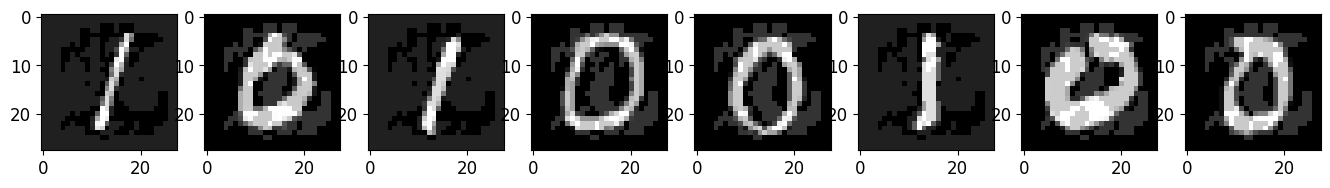

In [182]:
# Copy X_test to X_test_noisy for this additive noise attack
X_test_noisy = X_test.copy()

print(X_test_noisy.shape)
# Maximum offset between original and modified pixel values
max_noise = 32

# START EDITING HERE - DON'T REMOVE THIS COMMENT
'''
The goal here is to conduct a noise attack with max constraint = 32.
Meaning, we can change every pixel in in every single picture and move it
by a max of 32 in the direction of the a-vector in order to really destroy
the classifier which would be a straightforward attack and conducting that
straightforward attack in a closed box method provides .722, but we need .65

A bit of an unintuitive move here compared to the closed box method of moving
all toward and across the decision boundary since we have access to the labels
is to adjust the pixels according to the image that appears. So a 1 will go one
way and a 0 will go the other while retaining the 0-255 pixel value limit using
the min() and max() functions

For loop, iterate over all images that were correctly classified and apply noise
 i - shape[0] is all images 
 pix_idx - shape[1] is all pixels
'''
correct_classification = (predictions == y_test) 
# Iterate over all images that were correctly classified and apply noise shape[0] is all images 
for i in range(X_test_noisy.shape[0]):  # Iterate over each image
    if correct_classification[i]:  # Only modify correctly classified images
        # Iterate over all pixels in the image
        for pix_idx in range(X_test_noisy.shape[1]):
            if y_test[i] == 0:    
                if a[pix_idx] > 0:
                    X_test_noisy[i, pix_idx] = max(0, X_test_noisy[i, pix_idx] + max_noise)
                else:
                    X_test_noisy[i, pix_idx] = min(255, X_test_noisy[i, pix_idx] - max_noise)
            else:    
                if a[pix_idx] > 0:
                    X_test_noisy[i, pix_idx] = max(0, X_test_noisy[i, pix_idx] - max_noise)
                else:
                    X_test_noisy[i, pix_idx] = min(255, X_test_noisy[i, pix_idx] + max_noise)

# END EDITING HERE - DON'T REMOVE THIS COMMENT

# Find accuracy on modified testing set
predictions_noisy = classifier.predict(X_test_noisy)
accuracy_noisy = accuracy_score(y_test, predictions_noisy)
print('Accuracy:', "{:.3f}".format(accuracy_noisy))

# Display the first 8 modified test images
for i in range(8):
  plt.subplot(2, 8, i+1)
  plt.imshow(X_test_noisy[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplots_adjust(bottom=0, top=1, left=0, right=2)

### Defending against the additive noise attack

**3.3** (20 pts) You will now train a `robust_classifier` that performs well on both the original testing set `X_test` and the modified testing set `X_test_noisy`. Edit the training set (`X_train_robust`, `y_train_robust`), so that the accuracy on the concatenated testing set (`X_test_all`, `y_test_all`) exceeds 99%.

Note that you *cannot* use any information from the testing set in the training of `robust_classifier`, but you can use information from the training set and from the model `classifier`.

In [186]:
# Concatenate X_test and X_test_noisy into a single testing set X_test_all
X_test_all = np.concatenate((X_test, X_test_noisy), axis=0)
# Form corresponding y_test_all
y_test_all = np.concatenate((y_test, y_test), axis=0)

# START EDITING HERE - DON'T REMOVE THIS COMMENT

# Concatenate X_test and X_test_noisy into a single testing set X_test_all
X_test_all = np.concatenate((X_test, X_test_noisy), axis=0)
# Form corresponding y_test_all
y_test_all = np.concatenate((y_test, y_test), axis=0)

# START EDITING HERE - DON'T REMOVE THIS COMMENT
'''
Here the same transformation that was applied to the test data to create
test_noisy is applied to create train_noisy just like you would in feature engineering
except here we're basically adding synthetic data to add robustness to the classifier

I suspect we could add a small amount of performance by removing 2 of the 4 misclassified images
from x_test_all since they are duplicated by combining x_test and x_test_noisy. I didn't eliminate
them in x_test_noisy above because I wanted the already misclassified images.
'''
# Create a noisy version of the training set (similar to X_test_noisy)
X_train_noisy = X_train.copy()
max_noise = 32

# Same as test_noisy except
for i in range(X_train_noisy.shape[0]):
    for pix_idx in range(X_train_noisy.shape[1]):
        if y_train[i] == 0:    
            if a[pix_idx] > 0:
                X_train_noisy[i, pix_idx] = max(0, X_train_noisy[i, pix_idx] + max_noise)
            else:
                X_train_noisy[i, pix_idx] = min(255, X_train_noisy[i, pix_idx] - max_noise)
        else:    
            if a[pix_idx] > 0:
                X_train_noisy[i, pix_idx] = max(0, X_train_noisy[i, pix_idx] - max_noise)
            else:
                X_train_noisy[i, pix_idx] = min(255, X_train_noisy[i, pix_idx] + max_noise)

# y_train_robust is just the labels and simply adds the same labels to the noisy
X_train_robust = np.concatenate((X_train, X_train_noisy), axis=0)
y_train_robust = np.concatenate((y_train, y_train), axis=0)
# END EDITING HERE - DON'T REMOVE THIS COMMENT

# Train robust classifier
robust_classifier = SVC(kernel='linear', random_state=0)
robust_classifier.fit(X_train_robust, y_train_robust)

# Evaluate robust classifier on combined test set
predictions_robust = robust_classifier.predict(X_test_all)
accuracy_robust = accuracy_score(y_test_all, predictions_robust)
print('Accuracy:', "{:.3f}".format(accuracy_robust))

Accuracy: 0.999


## Problem 4: Classification using Random Forests (20 pts)

In this problem you will use scikit-learn's random forest classifier to distinguish between poisonous and edible mushrooms. Run the cell below to load and inspect the data. Notice that the attributes are categorical. You can look up their meaning at http://archive.ics.uci.edu/ml/datasets/Mushroom.

In [187]:
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
df = pd.read_table(url, sep=',', header=None)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


**4.1** (10 pts) Build a random forest to classify a mushroom as poisonous or edible based on its other attributes. Print out the class confusion matrix.

Note that a random forest classifier cannot handle categorical features. Convert each attribute into a set of indicator (or dummy) variables using `pd.get_dummies()`. This process is also known as one-hot encoding.

In [219]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# START EDITING HERE - DON'T REMOVE THIS COMMENT
'''
It didn't make sense to me to do without the train_test_split
so I imported it, and it still had perfect performance so despite
feeling like I did something wrong, I believe the classifier
was created correctly
'''
from sklearn.model_selection import train_test_split, cross_val_score

# Extract the label column before one hot encoding or else it will be very complicated
y = df[0] 

# One Hot Encode the features
X = pd.get_dummies(df.drop(columns=[0]))

# Split the data into training and testing sets (to avoid overfitting)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create classifier, train with fit and get labels with predict
mushroom_classifier = RandomForestClassifier(
                        criterion='entropy', # As discussed in class
                        max_features='sqrt', # General rule of thumb as mentioned in book but is default anyway
                                            )
mushroom_classifier.fit(X_train,y_train)
mush_predictions = mushroom_classifier.predict(X_test)

conf_matrix = confusion_matrix(y_test, mush_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Added cross-validation to assess model further
cv_scores = cross_val_score(mushroom_classifier, X, y, cv=5)
print("Mean cross-validation score:", cv_scores.mean())
cv_scores = cross_val_score(mushroom_classifier, X, y, cv=10)
print("Mean cross-validation score:", cv_scores.mean())
cv_scores = cross_val_score(mushroom_classifier, X, y, cv=20)
print("Mean cross-validation score:", cv_scores.mean())
# END EDITING HERE - DON'T REMOVE THIS COMMENT

Confusion Matrix:
[[1249    0]
 [   0 1189]]
Mean cross-validation score: 0.9262509283819629
Mean cross-validation score: 0.9658023255109398
Mean cross-validation score: 1.0


**4.2** (5 pts) What is the probability of being poisoned by eating a mushroom that your classifier predicts is edible?

WRITE YOUR ANSWER HERE:
Surprisingly 0% which makes me think I'm doing something wrong, but this is apparently a very "easy" ML dataset for classifiers. I couldn't sit with the 0% so I conducted a cross-validation assessment across various folds, and the model generalization reached 1.0 so I stand with 0%

**4.3** (5 pts) One-hot encoding converts each categorical attribute into several binary attributes. Explain why this process is better than keeping the total number of attributes the same by mapping each attribute's possible values to consecutive integers (e.g. for attribute 1, map b=0, c=1, x=2, f=3, k=4, s=5.) Limit your answer to 1-3 sentences.

WRITE YOUR ANSWER HERE:
One-hot encoding is a bit less important for a random forest as the model shouldn't infer an ordinal relationship, but the model could potentially incorrectly group integers at decision points by inferring numerical relationships. One-hot encoding ensures the categories get their own features making it easier to determine the importance of each category and decision tree.